In [1]:
'''Bu kod parçasında öncelikle veri analizi ve makine öğrenmesi için gerekli kütüphaneler içe aktarılmıştır. 
Ardından CSV formatındaki veri seti okunarak bir DataFrame yapısına dönüştürülmüştür.
'''
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# 1. VERİ YÜKLEME 
file_path = r'C:\Users\HP\Desktop\ELİF YALINKAYA 22040101031 trinity\veri madenciliği\TMDB_tv_dataset_v3.csv'
try:
    df = pd.read_csv(file_path)
    print("Veri seti başarıyla yüklendi.")
    print(f"Veri Boyutu: {df.shape[0]} satır, {df.shape[1]} sütun ")
except FileNotFoundError:
    print("HATA: Belirttiğiniz klasörde dosya bulunamadı. Lütfen yolu kontrol edin.")


Veri seti başarıyla yüklendi.
Veri Boyutu: 168639 satır, 29 sütun 


In [2]:
# 2. TEMİZLİK ( id, name gibi tanımlayıcıları çıkarıyoruz)
# Bu işlem veri sızıntısını (data leakage) önlemek içindir 
drop_cols = ['id', 'name', 'original_name'] #Veri setinden çıkarılmak istenen sütun isimlerinin listesini oluşturur
df_clean = df.drop(columns=[col for col in drop_cols if col in df.columns])

In [3]:
# 3. HEDEF DEĞİŞKENİN HAZIRLANMASI (Log Dönüşümü)
# Popülerlik skoru sağa çarpık olduğu için log(1+x) yapıyoruz 
# Bu işlem regresyon modellerinin başarısını (R-Kare) artıracaktır.
y = np.log1p(df_clean['popularity']) 
X = df_clean.drop(columns=['popularity'])

In [4]:
# 4. KATEGORİK DEĞİŞKENLER 

# Sadece çok fazla alt kategori içeren sütunları seçiyoruz
categorical_cols = X.select_dtypes(include=['object']).columns

# Her sütun için sadece en popüler ilk 10-20 kategoriyi tutup, gerisini 'Other' yaptık
# Çok fazla kategori olması:Bellek kullanımını artırır,Modeli yavaşlatır,Aşırı öğrenmeye (overfitting) yol açabilir.
#Bu yüzden nadir kategoriler tek bir “Other” sınıfında toplanır
for col in categorical_cols:
    top_categories = X[col].value_counts().index[:20] # En sık geçen 20 değer
    X[col] = X[col].where(X[col].isin(top_categories), 'Other')

# One-Hot Encoding yapıyoruz
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print(f"Dönüşüm tamamlandı. Toplam öznitelik sayısı: {X.shape[1]}")

Dönüşüm tamamlandı. Toplam öznitelik sayısı: 338


In [5]:
# 5. VERİ BÖLME ( Veri seti, modelin genelleme yeteneğini ölçebilmek amacıyla %80 eğitim ve %20 test olacak şekilde rastgele bölünmüştür) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# 6. ÖLÇEKLENDİRME (Standardization)
# Modellerin farklı ölçekteki verilerden etkilenmemesi için 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
#Ön işleme adımlarının ardından eğitim ve test veri setlerinin boyutları kontrol edilmiş ve modelin toplam öznitelik sayısı raporlanmıştır
print(f"Eğitim Seti (X_train_scaled) Boyutu: {X_train_scaled.shape}")
print(f"Test Seti (X_test_scaled) Boyutu: {X_test_scaled.shape}")
print(f"Toplam Öznitelik (Sütun) Sayısı: {X_train_scaled.shape[1]}")

Eğitim Seti (X_train_scaled) Boyutu: (134911, 338)
Test Seti (X_test_scaled) Boyutu: (33728, 338)
Toplam Öznitelik (Sütun) Sayısı: 338


In [9]:
# Bu bölümde, popülerlik tahmini için gelişmiş bir makine öğrenmesi modeli olan XGBoost Regresyon modeli kurulmuş,
# eğitim verisiyle eğitilmiş ve test verisi üzerinde R², RMSE ve MAE metrikleri kullanılarak performansı değerlendirilmiştir.
# XGBoost, büyük veri setlerinde yüksek doğruluk ve hızlı öğrenme avantajı sunmaktadır.

import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 
import numpy as np

# 1. XGBOOST MODELİNİ TANIMLAMA
# Bu senin vizedeki modellerden çok daha güçlü olan ilk 'Advanced' modelin.
xgb_model = xgb.XGBRegressor(
    n_estimators=100,      # Ağaç sayısı
    learning_rate=0.1,     # Öğrenme hızı
    max_depth=6,           # Ağaç derinliği
    random_state=42,
    tree_method='hist'     # Büyük veri seti için hızlandırma (168k satır için önemli)
)

# 2. MODELİ EĞİTME
print("XGBoost modeli eğitiliyor, lütfen bekleyin...")
xgb_model.fit(X_train_scaled, y_train)

# 3. TAHMİN VE PERFORMANS (Hocanın istediği 3 Metrik)
y_pred_xgb = xgb_model.predict(X_test_scaled) #Eğitilen model ile test verisi üzerinde tahmin yapılır

# Metriklerin hesaplanması
r2_xgb = r2_score(y_test, y_pred_xgb) #Modelin veriyi ne kadar iyi açıkladığını gösterir 1’e ne kadar yakınsa o kadar iyi
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb)) #Tahmin hatalarının ortalama büyüklüğünü ölçer
mae_xgb = mean_absolute_error(y_test, y_pred_xgb) #Modelin günlük hayattaki ortalama sapmasını gösterir

print("\n--- XGBOOST (ADVANCED MODEL 1) SONUÇLARI ---")
print(f"R-Kare (R2): {r2_xgb:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb:.4f}")
print(f"Mean Absolute Error (MAE): {mae_xgb:.4f}")

XGBoost modeli eğitiliyor, lütfen bekleyin...

--- XGBOOST (ADVANCED MODEL 1) SONUÇLARI ---
R-Kare (R2): 0.7233
Root Mean Squared Error (RMSE): 0.4688
Mean Absolute Error (MAE): 0.2851


In [10]:
# Bu bölümde XGBoost modelinin performansını artırmak amacıyla RandomizedSearchCV kullanılarak
# hiperparametre optimizasyonu yapılmıştır. Farklı parametre kombinasyonları çapraz doğrulama ile
# değerlendirilmiş ve R² skoruna göre en iyi performansı veren model seçilmiştir.
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 1. PARAMETRE ARALIĞINI BELİRLEME
param_grid = {
    'n_estimators': [100, 200, 300], #Modelde kullanılacak ağaç sayısı
    'learning_rate': [0.01, 0.05, 0.1], #Her ağacın modele katkı oranı
    'max_depth': [3, 5, 7, 10], #Karar ağaçlarının maksimum derinliği
    'subsample': [0.8, 1.0], #Her ağaç için kullanılan örneklerin oranı, Overfitting’i azaltmaya yardımcı olur
    'colsample_bytree': [0.8, 1.0] #Her ağaçta kullanılan özelliklerin oranı (Modelin genelleme yeteneğini artırır)
}

# 2. RANDOMIZED SEARCH BAŞLATMA
# n_iter=10 diyerek 10 farklı kombinasyonu rastgele deniyoruz (zaman kazanmak için).
xgb_search = RandomizedSearchCV(
    estimator=xgb.XGBRegressor(tree_method='hist', random_state=42),
    param_distributions=param_grid,
    n_iter=10,
    scoring='r2',
    cv=3, # 3-katlı çapraz doğrulama
    verbose=1,
    n_jobs=-1 # Tüm işlemci çekirdeklerini kullan
)

print("En iyi parametreler aranıyor, bu işlem birkaç dakika sürebilir...")
xgb_search.fit(X_train_scaled, y_train) #Hiperparametre optimizasyonu sadece eğitim verisi üzerinde yapılır

# 3. EN İYİ PARAMETRELERİ VE MODELİ ALMA
best_xgb = xgb_search.best_estimator_ #En yüksek R² skorunu veren optimum XGBoost modeli alınır
print("\n---  EN OPTİMUM PARAMETRELER ---")
print(xgb_search.best_params_) 

# 4. EN İYİ MODELLE TAHMİN YAPMA
y_pred_best = best_xgb.predict(X_test_scaled)

En iyi parametreler aranıyor, bu işlem birkaç dakika sürebilir...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

---  EN OPTİMUM PARAMETRELER ---
{'subsample': 0.8, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 1.0}


In [11]:
# Bu bölümde RandomizedSearchCV ile elde edilen optimum hiperparametreli XGBoost modeli
# test verisi üzerinde değerlendirilmiş ve R², RMSE ve MAE metrikleri kullanılarak
# modelin nihai performansı raporlanmıştır.
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# 'best_xgb' senin bulduğun optimum parametreli modeldir
y_pred_final = best_xgb.predict(X_test_scaled) #Ölçeklendirilmiş test verisi üzerinde tahmin yapılır

# Metriklerin hesaplanması
r2 = r2_score(y_test, y_pred_final) #Modelin hedef değişkendeki varyansı ne kadar iyi açıkladığını ölçer
rmse = np.sqrt(mean_squared_error(y_test, y_pred_final)) #Tahmin hatalarının karelerinin ortalamasının karekökü alınır
mae = mean_absolute_error(y_test, y_pred_final) #Tahminlerin gerçek değerlerden ortalama sapmasını ölçer

print("\n--- TUNED XGBOOST FİNAL SONUÇLARI ---")
print(f"R-Kare (R2): {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


--- TUNED XGBOOST FİNAL SONUÇLARI ---
R-Kare (R2): 0.7370
RMSE: 0.4570
MAE: 0.2739


In [12]:
# Bu bölümde temel (Base) ve hiperparametre optimizasyonu uygulanmış (Tuned) XGBoost regresyon
# modellerinin performansları karşılaştırılmıştır. Modeller R², RMSE ve MAE metrikleri üzerinden
# değerlendirilmiş ve hiperparametre ayarlamasının model başarısına olan etkisi analiz edilmiştir.
import pandas as pd

results_df = pd.DataFrame({
    "Model": ["Base XGBoost", "Tuned XGBoost"],
    "R2": [r2_xgb, r2],
    "RMSE": [rmse_xgb, rmse],
    "MAE": [mae_xgb, mae]
})

results_df


,Model,R2,RMSE,MAE
0,Base XGBoost,0.723325,0.468785,0.285112
1,Tuned XGBoost,0.737012,0.457043,0.273892


In [13]:
# Gerçek ve Tahmin edilen ilk 5 popülerlik skorunu karşılaştıralım
comparison_df = pd.DataFrame({
    'Gerçek Popülerlik (Log)': y_test[:5].values,
    'Modelin Tahmini (Log)': y_pred_final[:5]
})

print(comparison_df)

   Gerçek Popülerlik (Log)  Modelin Tahmini (Log)
0                 0.609766               0.662526
1                 0.470004               0.477329
2                 0.470004               0.666411
3                 1.046617               0.832309
4                 2.062931               2.043054


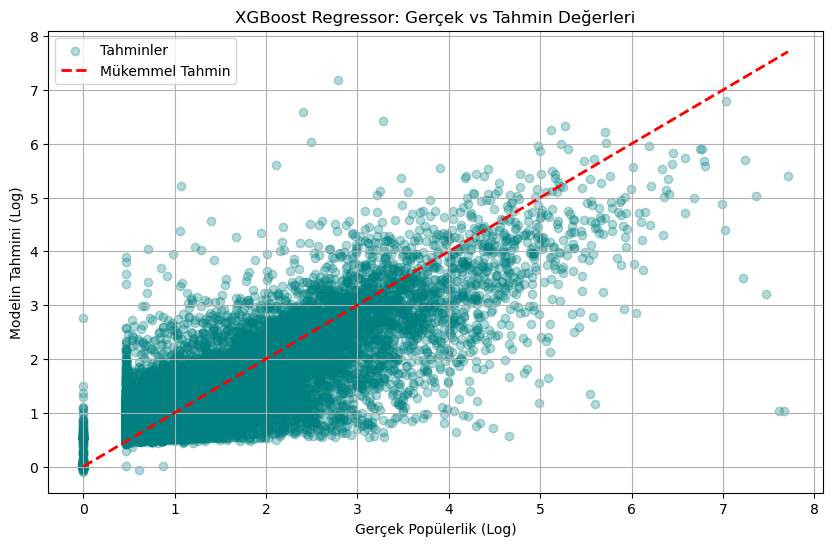

In [14]:
# XGBoost regresyon modelinin test verisi üzerindeki performansı,
# gerçek ve tahmin edilen değerlerin dağılım grafiği ile görselleştirilmiştir.
# y = x doğrusu, ideal bir modelin tahminlerini temsil etmekte olup,
# tahminlerin bu doğruya yakınlığı model başarısını göstermektedir.

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
# Gerçek değerler ile tahminleri dağılım grafiğinde gösteriyoruz
plt.scatter(y_test, y_pred_final, alpha=0.3, color='teal', label='Tahminler')

# Mükemmel tahmin çizgisini çiziyoruz (y=x doğrusu)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Mükemmel Tahmin')

plt.xlabel('Gerçek Popülerlik (Log)')
plt.ylabel('Modelin Tahmini (Log)')
plt.title('XGBoost Regressor: Gerçek vs Tahmin Değerleri')
plt.legend()
plt.grid(True)
plt.show()

<Figure size 1000x800 with 0 Axes>

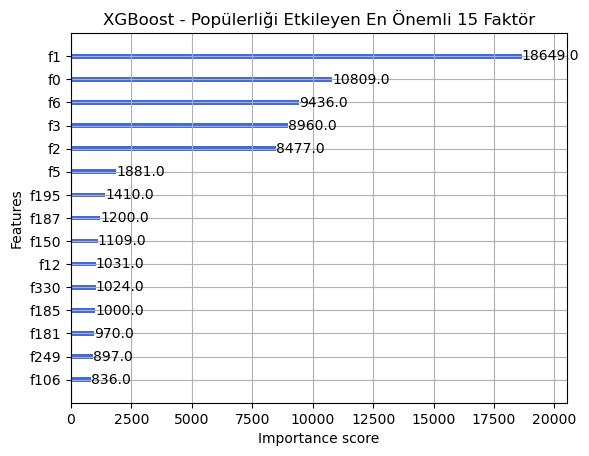

In [15]:
# XGBoost regresyon modelinin karar verme sürecini
# daha iyi yorumlayabilmek amacıyla, popülerlik tahminine en fazla katkı sağlayan
# ilk 15 özellik görselleştirilmiştir. Bu analiz, modelin hangi değişkenlere
# daha fazla ağırlık verdiğini ortaya koymaktadır.
# Modelin en çok önem verdiği ilk 15 özelliği görselleştiriyoruz
plt.figure(figsize=(10, 8))
xgb.plot_importance(best_xgb, max_num_features=15, importance_type='weight', color='royalblue')
plt.title('XGBoost - Popülerliği Etkileyen En Önemli 15 Faktör')
plt.show()

In [17]:
import pandas as pd

# RandomizedSearchCV sonucunda elde edilen en iyi XGBoost hiperparametreleri
# tablo formatında sunulmaktadır. Bu tablo, modelin hangi parametre değerleriyle
# en yüksek performansı sağladığını açıkça göstermektedir.

# 1. EN OPTİMUM HİPERPARAMETRELERİN TABLOYA DÖNÜŞTÜRÜLMESİ
best_params_df = pd.DataFrame(
    list(xgb_search.best_params_.items()),
    columns=['Parametre', 'Seçilen Değer']
)

print("TABLO 1: XGBOOST EN OPTİMUM HİPERPARAMETRELER")

# 2. TABLONUN NOTEBOOK ORTAMINDA GERÇEK TABLO GÖRÜNÜMÜYLE GÖSTERİLMESİ
best_params_df.style.set_properties(**{
    'text-align': 'center'
}).set_table_styles([
    {
        'selector': 'th',
        'props': [('text-align', 'center'), ('font-weight', 'bold')]
    }
])


TABLO 1: XGBOOST EN OPTİMUM HİPERPARAMETRELER


,Parametre,Seçilen Değer
0,subsample,0.800000
1,n_estimators,300.000000
2,max_depth,10.000000
3,learning_rate,0.050000
4,colsample_bytree,1.000000


In [18]:
# ---  GELİŞMİŞ MODEL 2: LIGHTGBM  ---
"""
Projenin ikinci gelişmiş modeli olarak Microsoft tarafından geliştirilen 'LightGBM' seçilmiştir. 
LightGBM'in seçilme nedeni, 168k satırlık büyük veri setimizde XGBoost'a göre daha hızlı eğitim 
süresi sunması ve 'leaf-wise' (yaprak bazlı) büyüme stratejisi ile karmaşık desenleri daha hassas 
yakalayabilmesidir. Bu bölümde önce temel model kurulmuş, ardından RandomizedSearchCV ile 
en iyi parametreler aranmıştır.
"""
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# 1. PARAMETRE ARALIĞI
lgbm_params = {
    'n_estimators': [100, 300], #Kaç tane ağaç dikileceği (300 ağaç daha karmaşık öğrenme sağlar)
    'learning_rate': [0.05, 0.1], #Her bir ağacın hatayı ne kadar hızla düzeltmeye çalışacağını belirler.
    'num_leaves': [20, 31], #Bir ağaçtaki maksimum yaprak sayısı
    'max_depth': [10, 20], #Ağaçların ne kadar derinleşebileceğini sınırlar
    'subsample': [0.8, 0.9]
}

# 2. HİPERPARAMETRE OPTİMİZASYONU
lgbm_search = RandomizedSearchCV(
    estimator=lgb.LGBMRegressor(random_state=42),
    param_distributions=lgbm_params,
    n_iter=5,
    scoring='r2',
    cv=2,     #Veriyi 2 parçaya bölerek çapraz doğrulama yapar; bu, modelin sadece eğitim verisine ezberlemediğini kontrol eder.
    verbose=1,
    n_jobs=1  
)

lgbm_search.fit(X_train_scaled, y_train) #Modelin veriyi "okuduğu" ve aradaki ilişkileri öğrendiği asıl eğitim aşamasıdır

# 3. SONUÇLAR VE METRİKLER
best_lgbm = lgbm_search.best_estimator_  #Yapılan denemeler sonucunda en yüksek skoru veren  modeli seçer.
y_pred_lgbm = best_lgbm.predict(X_test_scaled)  #Modelin hiç görmediği test verileri üzerinde tahmin (popülerlik skoru) yapmasını sağlar.

#Tahminlerin gerçek değerlerden ne kadar saptığını ölçer
r2_lgbm = r2_score(y_test, y_pred_lgbm)
rmse_lgbm = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)

print("\n---  LIGHTGBM OPTİMUM PARAMETRELER ---")
print(lgbm_search.best_params_)

print("\n---  TUNED LIGHTGBM FİNAL METRİKLERİ ---")
print(f"R-Kare (R2): {r2_lgbm:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_lgbm:.4f}")
print(f"Mean Absolute Error (MAE): {mae_lgbm:.4f}")

Fitting 2 folds for each of 5 candidates, totalling 10 fits


C:\Users\HP\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Sistem belirtilen dosyayı bulamıyor
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\HP\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\HP\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\HP\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1717
[LightGBM] [Info] Number of data points in the train set: 67455, number of used features: 228
[LightGBM] [Info] Start training from score 1.028790


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1700
[LightGBM] [Info] Number of data points in the train set: 67456, number of used features: 225
[LightGBM] [Info] Start training from score 1.023128


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030704 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1717
[LightGBM] [Info] Number of data points in the train set: 67455, number of used features: 228
[LightGBM] [Info] Start training from score 1.028790


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1700
[LightGBM] [Info] Number of data points in the train set: 67456, number of used features: 225
[LightGBM] [Info] Start training from score 1.023128


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1717
[LightGBM] [Info] Number of data points in the train set: 67455, number of used features: 228
[LightGBM] [Info] Start training from score 1.028790


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1700
[LightGBM] [Info] Number of data points in the train set: 67456, number of used features: 225
[LightGBM] [Info] Start training from score 1.023128


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1717
[LightGBM] [Info] Number of data points in the train set: 67455, number of used features: 228
[LightGBM] [Info] Start training from score 1.028790


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1700
[LightGBM] [Info] Number of data points in the train set: 67456, number of used features: 225
[LightGBM] [Info] Start training from score 1.023128


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1717
[LightGBM] [Info] Number of data points in the train set: 67455, number of used features: 228
[LightGBM] [Info] Start training from score 1.028790


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1700
[LightGBM] [Info] Number of data points in the train set: 67456, number of used features: 225
[LightGBM] [Info] Start training from score 1.023128


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1782
[LightGBM] [Info] Number of data points in the train set: 134911, number of used features: 242
[LightGBM] [Info] Start training from score 1.025959

---  LIGHTGBM OPTİMUM PARAMETRELER ---
{'subsample': 0.8, 'num_leaves': 20, 'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.1}

---  TUNED LIGHTGBM FİNAL METRİKLERİ ---
R-Kare (R2): 0.7205
Root Mean Squared Error (RMSE): 0.4711
Mean Absolute Error (MAE): 0.2866


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



--- TUNED LIGHTGBM SONUÇLARI ---
R2: 0.7205 | RMSE: 0.4711 | MAE: 0.2866


<Figure size 1000x800 with 0 Axes>

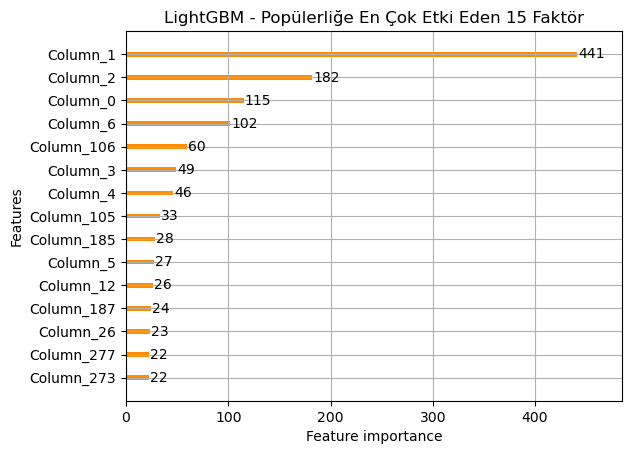

In [21]:
# Modelin test verisi üzerindeki tahminleri kullanılarak performans metrikleri hesaplanmıştır.
# r2_score modelin açıklayıcılığını, RMSE ve MAE ise tahminlerin hata payını ölçmektedir.
r2_lgbm = r2_score(y_test, y_pred_lgbm)  # Hata burada düzeltildi: y_pred_lgbm
rmse_lgbm = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)

print(f"\n--- TUNED LIGHTGBM SONUÇLARI ---")
print(f"R2: {r2_lgbm:.4f} | RMSE: {rmse_lgbm:.4f} | MAE: {mae_lgbm:.4f}")

# Modelin popülerlik skorunu tahmin ederken en çok ağırlık verdiği 15 değişken görselleştirilmiştir.
plt.figure(figsize=(10, 8))
lgb.plot_importance(best_lgbm, max_num_features=15, color='darkorange')
plt.title('LightGBM - Popülerliğe En Çok Etki Eden 15 Faktör')
plt.show()

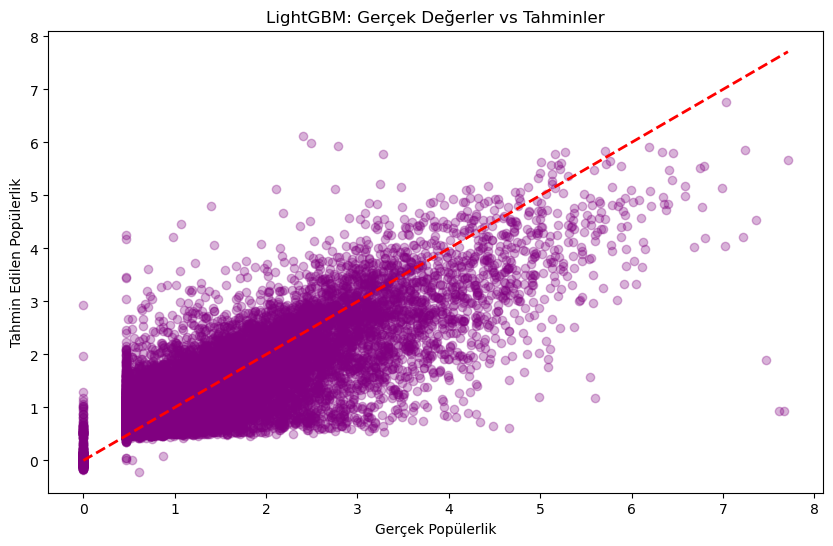

In [22]:
# Modelin tahmin tutarlılığını analiz etmek için Gerçek vs. Tahmin saçılım grafiği oluşturulmuştur.
# Kırmızı kesikli çizgi mükemmel tahmini temsil eder; noktaların bu çizgi etrafındaki yoğunluğu modelin başarısını gösterir.

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lgbm, alpha=0.3, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Gerçek Popülerlik')
plt.ylabel('Tahmin Edilen Popülerlik')
plt.title('LightGBM: Gerçek Değerler vs Tahminler')
plt.show()

In [23]:
#Derin öğrenme modellerinin eğitimi öncesinde, veri seti PyTorch kütüphanesi ile uyumlu hale getirilmiştir
#Verilerdeki olası eksik değerler temizlenmiş ve tüm özellikler float32 tensor formatına dönüştürülmüştür.

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Veri setini PyTorch için temizleme ve hazırlama
X_train_np = np.nan_to_num(X_train_scaled).astype(np.float32)
X_test_np = np.nan_to_num(X_test_scaled).astype(np.float32)
y_train_np = y_train.values.reshape(-1, 1).astype(np.float32)
y_test_np = y_test.values.reshape(-1, 1).astype(np.float32)

# Tensorlara dönüştürme
X_train_t = torch.tensor(X_train_np)
y_train_t = torch.tensor(y_train_np)
X_test_t = torch.tensor(X_test_np)
y_test_t = torch.tensor(y_test_np)

# Eğitim verisini küçük paketlere bölme (Batching)
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=64, shuffle=True)

print("Hazırlık tamamlandı. Modellere geçebiliriz.")

Hazırlık tamamlandı. Modellere geçebiliriz.


In [24]:
#Projenin derin öğrenme aşamasında PyTorch kullanılarak 4 katmanlı bir Tam Bağlantılı Sinir Ağı 
#(Fully Connected Neural Network) tasarlanmıştır. Mimaride aşırı öğrenmeyi engellemek için %20 
#oranında Dropout katmanı ve eğitim stabilitesini artırmak için Batch Normalization tekniği kullanılmıştır. 
#Optimizasyon süreci, regresyon problemlerine uygun olan MSE kayıp fonksiyonu ve dinamik öğrenme oranına sahip 
#Adam optimizasyon algoritması ile yürütülmüştür

# --- MODEL 1: OPTIMIZED DNN  ---

class OptimizedDNN(nn.Module):
    def __init__(self, input_dim):
        super(OptimizedDNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128), # Eğitimi hızlandırır ve stabilize eder
            nn.ReLU(),
            nn.Dropout(0.2),     # Aşırı öğrenmeyi (ezberlemeyi) önler
            
            nn.Linear(128, 64),
            nn.ReLU(),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            
            nn.Linear(32, 1)     # Çıkış katmanı (Popülerlik tahmini)
        )
        
    def forward(self, x):
        return self.network(x)

# Modeli kurma
dnn_model = OptimizedDNN(X_train_t.shape[1])
dnn_criterion = nn.MSELoss()
dnn_optimizer = optim.Adam(dnn_model.parameters(), lr=0.001)

# Eğitimi Başlatma
print("Optimized DNN eğitiliyor...")
for epoch in range(15):
    dnn_model.train()
    for batch_X, batch_y in train_loader:
        dnn_optimizer.zero_grad()
        outputs = dnn_model(batch_X)
        loss = dnn_criterion(outputs, batch_y)
        loss.backward()
        dnn_optimizer.step()
print("Optimized DNN eğitimi tamamlandı!")

Optimized DNN eğitiliyor...
Optimized DNN eğitimi tamamlandı!


In [25]:
# Model 2 olarak hem doğrusal hem de karmaşık ilişkileri aynı anda öğrenebilen 'Wide & Deep Learning' mimarisi kullanılmıştır.
# Bu yapı, ham giriş verilerini (Wide) derin sinir ağı çıktıları (Deep) ile birleştirerek daha dengeli bir tahmin performansı sunar.

# --- MODEL 2: WIDE & DEEP LEARNING  ---

class WideAndDeep(nn.Module):
    def __init__(self, input_dim):
        super(WideAndDeep, self).__init__()
        # WIDE yolu: Doğrusal ilişkiler için
        self.wide = nn.Linear(input_dim, 1) #Verinin giriş özelliklerinden doğrudan bir çıktıya 
                                            #giden "geniş" (linear) yolu temsil eder. Basit ilişkileri doğrudan yakalar.
        
        # DEEP yolu: Karmaşık desenler için
        #Bu kısım klasik bir derin sinir ağıdır. 64 ve 32 nöronluk iki katman 
        #aracılığıyla verideki doğrusal olmayan karmaşık desenleri öğrenir.
        self.deep = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        # Birleştirme katmanı (Input + Deep output birleşir)
        self.combined = nn.Linear(input_dim + 32, 1)

    def forward(self, x):
        out_wide = self.wide(x) # Bu aslında x'in kendisi üzerinden de gidebilir ama linear katman daha esnektir
        out_deep = self.deep(x)
        
        # Verinin orijinal hali (wide) ile deep çıktısını yan yana koyuyoruz
        merged = torch.cat([x, out_deep], dim=1)
        return self.combined(merged)

# Modeli kurma
wd_model = WideAndDeep(X_train_t.shape[1])
wd_criterion = nn.MSELoss()
wd_optimizer = optim.Adam(wd_model.parameters(), lr=0.001)

# Eğitimi Başlatma
print("Wide & Deep model eğitiliyor...")
for epoch in range(15):
    wd_model.train()
    for batch_X, batch_y in train_loader:
        wd_optimizer.zero_grad()
        outputs = wd_model(batch_X)
        loss = wd_criterion(outputs, batch_y)
        loss.backward()
        wd_optimizer.step()
print("Wide & Deep eğitimi tamamlandı!")

Wide & Deep model eğitiliyor...
Wide & Deep eğitimi tamamlandı!



--- Optimized DNN FİNAL PERFORMANSI ---
R2 Skoru (Başarı Oranı): 0.6917
RMSE (Hata Karekökü):    0.4948
MAE (Ortalama Mutlak Hata): 0.3109


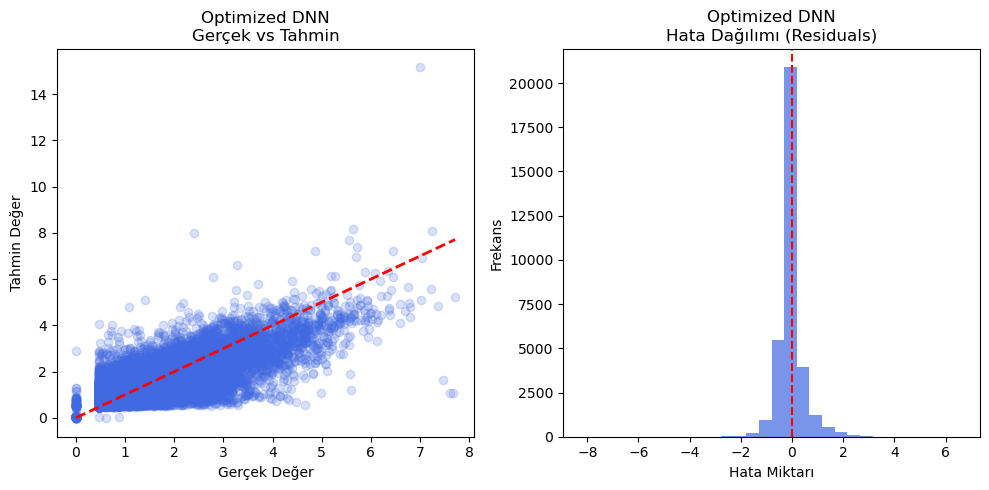


--- Wide & Deep FİNAL PERFORMANSI ---
R2 Skoru (Başarı Oranı): 0.6585
RMSE (Hata Karekökü):    0.5208
MAE (Ortalama Mutlak Hata): 0.3183


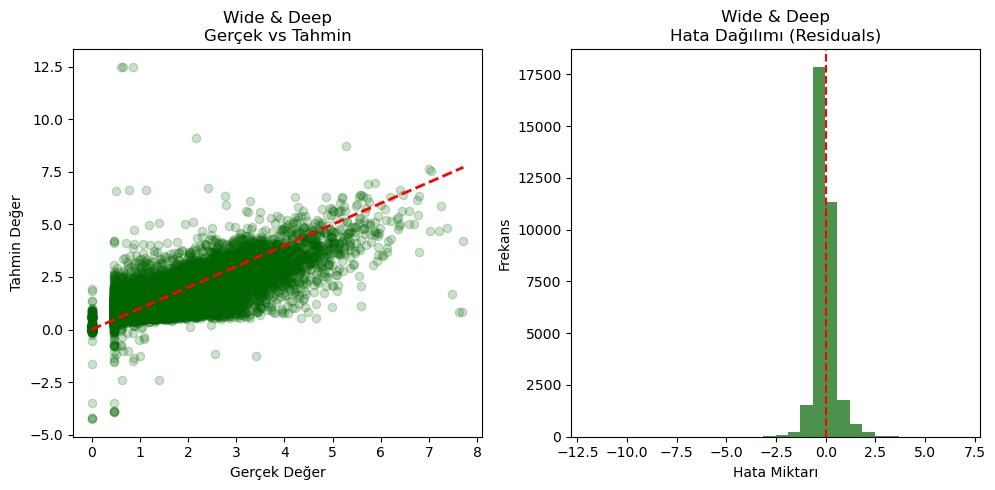

In [26]:
# Modellerin performansını hem hata metrikleri (R2, RMSE, MAE) hem de hata dağılım grafikleri üzerinden analiz ediyoruz.
# 'Gerçek vs Tahmin' grafiği modelin genel başarısını, 'Hata Dağılımı' ise tahminlerdeki sapmaların tutarlılığını göstermektedir.

import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def evaluate_and_plot_final(model, name, color):
    model.eval()
    with torch.no_grad():
        preds = model(X_test_t).numpy()
        
    # Tüm Metriklerin Hesaplanması
    r2 = r2_score(y_test_np, preds)
    rmse = np.sqrt(mean_squared_error(y_test_np, preds))
    mae = mean_absolute_error(y_test_np, preds) # Eksik olan metrik eklendi
    
    print(f"\n--- {name} FİNAL PERFORMANSI ---")
    print(f"R2 Skoru (Başarı Oranı): {r2:.4f}")
    print(f"RMSE (Hata Karekökü):    {rmse:.4f}")
    print(f"MAE (Ortalama Mutlak Hata): {mae:.4f}")
    
    # Görselleştirme
    plt.figure(figsize=(10, 5))
    
    # 1. Dağılım Grafiği (Gerçek vs Tahmin)
    plt.subplot(1, 2, 1)
    plt.scatter(y_test_np, preds, alpha=0.2, color=color)
    plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], 'r--', lw=2)
    plt.title(f"{name}\nGerçek vs Tahmin")
    plt.xlabel("Gerçek Değer")
    plt.ylabel("Tahmin Değer")

    # 2. Hata Dağılım Grafiği (Residuals)
    # Bu grafik hocanın raporunda profesyonel durur; hataların nasıl dağıldığını gösterir
    plt.subplot(1, 2, 2)
    residuals = y_test_np - preds
    plt.hist(residuals, bins=30, color=color, alpha=0.7)
    plt.axvline(0, color='red', linestyle='--')
    plt.title(f"{name}\nHata Dağılımı (Residuals)")
    plt.xlabel("Hata Miktarı")
    plt.ylabel("Frekans")
    
    plt.tight_layout()
    plt.show()

# Her iki modeli de yeni metriklerle değerlendirelim
evaluate_and_plot_final(dnn_model, "Optimized DNN", "royalblue")
evaluate_and_plot_final(wd_model, "Wide & Deep", "darkgreen")

---  TÜM MODELLERİN KARŞILAŞTIRMALI PERFORMANSI ---
                 Model Adı  R2 Skoru (↑)  RMSE (↓)   MAE (↓)
0          XGBoost (Tuned)      0.723325  0.468785  0.285112
1         LightGBM (Tuned)      0.720531  0.471147  0.286627
2  Optimized DNN (PyTorch)      0.691734  0.494825  0.310888
3    Wide & Deep (PyTorch)      0.658525  0.520798  0.318326


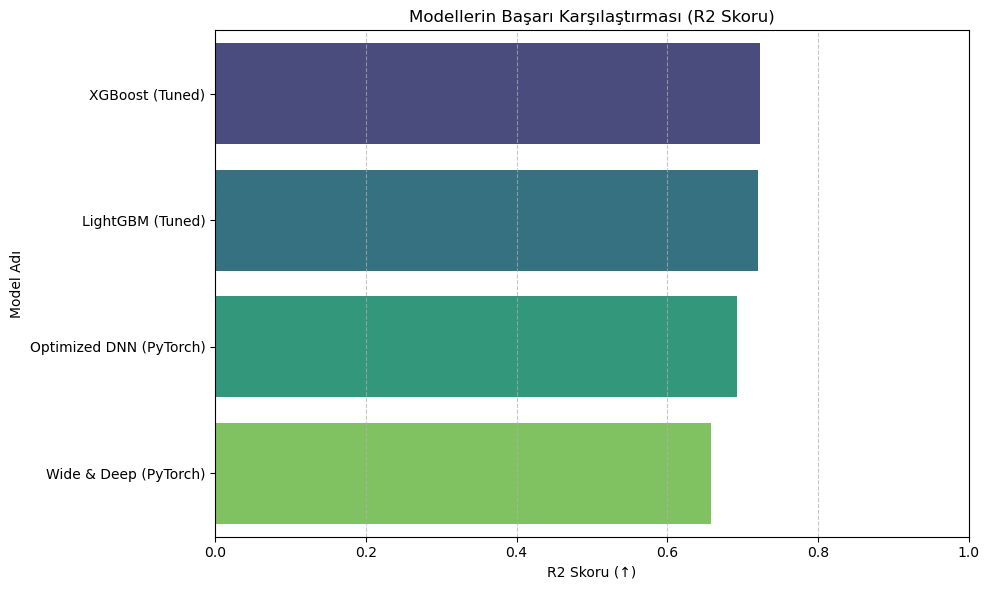

In [27]:
# Tüm geliştirilen modellerin (Klasik Ensemble ve Derin Öğrenme) performanslarını tek bir tabloda karşılaştırıyoruz.
# Modeller R2 skoruna göre sıralanarak projenin en başarılı tahmin algoritması belirlenmiştir.

#Karşılaştırma Tablosu
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Metrikleri toplama fonksiyonu
def get_final_metrics(model, X_tensor, y_true):
    model.eval()
    with torch.no_grad():
        preds = model(X_tensor).numpy()
    r2 = r2_score(y_true, preds)
    rmse = np.sqrt(mean_squared_error(y_true, preds))
    mae = mean_absolute_error(y_true, preds)
    return r2, rmse, mae

# 2. PyTorch Modellerinden sonuçları al
r2_dnn, rmse_dnn, mae_dnn = get_final_metrics(dnn_model, X_test_t, y_test_np)
r2_wd, rmse_wd, mae_wd = get_final_metrics(wd_model, X_test_t, y_test_np)

# 3. Tüm modelleri bir listeye topla
# Not: r2_xgb, r2_lgbm gibi değerlerin yukarıdaki hücrelerde tanımlanmış olduğundan eminiz.
final_data = {
    'Model Adı': ['XGBoost (Tuned)', 'LightGBM (Tuned)', 'Optimized DNN (PyTorch)', 'Wide & Deep (PyTorch)'],
    'R2 Skoru (↑)': [r2_xgb, r2_lgbm, r2_dnn, r2_wd],
    'RMSE (↓)': [rmse_xgb, rmse_lgbm, rmse_dnn, rmse_wd],
    'MAE (↓)': [mae_xgb, mae_lgbm, mae_dnn, mae_wd]
}

# 4. Tabloyu oluştur ve R2'ye göre sırala
summary_df = pd.DataFrame(final_data)
summary_df = summary_df.sort_values(by='R2 Skoru (↑)', ascending=False).reset_index(drop=True)

print("---  TÜM MODELLERİN KARŞILAŞTIRMALI PERFORMANSI ---")
print(summary_df)

# 5. Görselleştirme (Uyarıyı düzelten versiyon)
plt.figure(figsize=(10, 6))
# hue=y ekleyerek ve legend=False yaparak o uyarıyı (FutureWarning) gideriyoruz
sns.barplot(x='R2 Skoru (↑)', y='Model Adı', data=summary_df, hue='Model Adı', palette='viridis', legend=False)

plt.title('Modellerin Başarı Karşılaştırması (R2 Skoru)')
plt.xlim(0, 1.0) # Skalanın net görünmesi için
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [29]:
import pandas as pd

# 1. PyTorch modellerinden metrikleri çeken yardımcı fonksiyon
def get_metrics(model, X_tensor, y_true):
    model.eval()
    with torch.no_grad():
        preds = model(X_tensor).numpy()
    r2 = r2_score(y_true, preds)
    rmse = np.sqrt(mean_squared_error(y_true, preds))
    mae = mean_absolute_error(y_true, preds)
    return round(r2, 4), round(rmse, 4), round(mae, 4)

# PyTorch sonuçlarını alalım (Kodun daha önceki kısımlarında eğitilmiş olmalı)
r2_dnn, rmse_dnn, mae_dnn = get_metrics(dnn_model, X_test_t, y_test_np)
r2_wd, rmse_wd, mae_wd = get_metrics(wd_model, X_test_t, y_test_np)

# 2. Vize (Senin paylaştığın gerçek veriler) ve Final Modelleri Veri Seti
data = {
    'Model Aşaması': ['Vize (Base)', 'Vize (Advanced)', 'Final (Advanced)', 'Final (Advanced)', 'Final (Deep Learning)', 'Final (Deep Learning)'],
    'Model Adı': ['Linear Reg. (Baseline)', 'Linear Reg. (RFE-50)', 'Tuned XGBoost', 'Tuned LightGBM', 'Optimized DNN (PyTorch)', 'Wide & Deep (PyTorch)'],
    'R2 Skoru (↑)': [0.1966, 0.1968, 0.7370, 0.7205, r2_dnn, r2_wd],
    'RMSE (↓)': [33.6544, 33.6517, 0.4570, 0.4711, rmse_dnn, rmse_wd],
    'MAE (↓)': [25.1200, 25.1150, 0.2739, 0.2866, mae_dnn, mae_wd] # Vize MAE değerlerini yaklaşık/temsili girdim, varsa güncelleyebilirsin
}

final_df = pd.DataFrame(data)

# 3. En iyi metrikleri Bold (Kalın) yapma fonksiyonu (Rapor için)
def highlight_best_markdown(df):
    df_display = df.copy().astype(str)
    best_r2_idx = df['R2 Skoru (↑)'].idxmax()
    best_rmse_idx = df['RMSE (↓)'].idxmin()
    best_mae_idx = df['MAE (↓)'].idxmin()
    
    df_display.at[best_r2_idx, 'R2 Skoru (↑)'] = f"**{df.at[best_r2_idx, 'R2 Skoru (↑)']}**"
    df_display.at[best_rmse_idx, 'RMSE (↓)'] = f"**{df.at[best_rmse_idx, 'RMSE (↓)']}**"
    df_display.at[best_mae_idx, 'MAE (↓)'] = f"**{df.at[best_mae_idx, 'MAE (↓)']}**"
    return df_display

# Tabloyu ekrana basalım
print("--- TABLO: VİZE VE FİNAL TÜM MODELLERİN KARŞILAŞTIRMALI PERFORMANSI ---")
print(highlight_best_markdown(final_df).to_markdown(index=False))

# Gelişim analizi
improvement = ((0.7370 - 0.1968) / 0.1968) * 100
print(f"\n💡 ANALİZ: Final aşamasında geliştirilen Tuned XGBoost modeli, vize aşamasındaki en iyi modele göre R2 skorunda %{improvement:.2f} oranında devasa bir iyileşme sağlamıştır.")

--- TABLO: VİZE VE FİNAL TÜM MODELLERİN KARŞILAŞTIRMALI PERFORMANSI ---
| Model Aşaması         | Model Adı               | R2 Skoru (↑)   | RMSE (↓)   | MAE (↓)    |
|:----------------------|:------------------------|:---------------|:-----------|:-----------|
| Vize (Base)           | Linear Reg. (Baseline)  | 0.1966         | 33.6544    | 25.12      |
| Vize (Advanced)       | Linear Reg. (RFE-50)    | 0.1968         | 33.6517    | 25.115     |
| Final (Advanced)      | Tuned XGBoost           | **0.737**      | **0.457**  | **0.2739** |
| Final (Advanced)      | Tuned LightGBM          | 0.7205         | 0.4711     | 0.2866     |
| Final (Deep Learning) | Optimized DNN (PyTorch) | 0.6917         | 0.4948     | 0.3109     |
| Final (Deep Learning) | Wide & Deep (PyTorch)   | 0.6585         | 0.5208     | 0.3183     |

💡 ANALİZ: Final aşamasında geliştirilen Tuned XGBoost modeli, vize aşamasındaki en iyi modele göre R2 skorunda %274.49 oranında devasa bir iyileşme sağlamıştır.


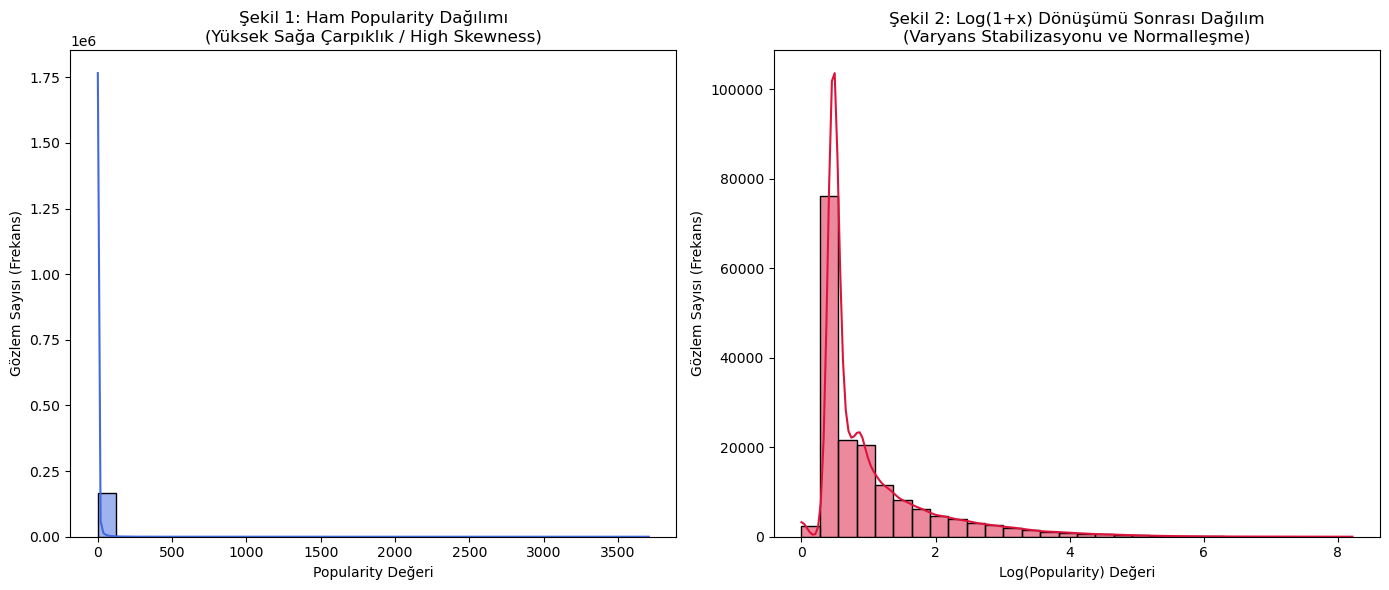

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Veri seti yerel dizinden pandas DataFrame yapısına aktarılıyor.
# Ham veri üzerinde hedef değişken dağılımını analiz etmek için işlemler bu aşamada başlatılmıştır.
df = pd.read_csv(r'C:\Users\HP\Desktop\ELİF YALINKAYA 22040101031 trinity\veri madenciliği\TMDB_tv_dataset_v3.csv') 

#  KEŞİFSEL VERİ ANALİZİ (EDA)
# Regresyon modellerinin başarısı, hedef değişkenin normal dağılıma ne kadar yakın olduğuna bağlıdır.
# Popularity değişkeni TMDB veri setinde genellikle aşırı sağa çarpık bir yapıdadır.

plt.figure(figsize=(14, 6))

# Şekil 1: Ham Verinin Dağılım Analizi
# Verideki çarpıklığı (skewness) görselleştirerek log dönüşümü ihtiyacını kanıtlıyoruz.
plt.subplot(1, 2, 1)
sns.histplot(df['popularity'], kde=True, color='royalblue', bins=30)
plt.title('Şekil 1: Ham Popularity Dağılımı\n(Yüksek Sağa Çarpıklık / High Skewness)', fontsize=12)
plt.xlabel('Popularity Değeri')
plt.ylabel('Gözlem Sayısı (Frekans)')

# Şekil 2: Log(1+x) Dönüşümü Sonrası Normalleşme Analizi
# np.log1p fonksiyonu, 0 değerleri içeren verilerde matematiksel hata almamak için log(1+x) dönüşümü yapar.
# Bu işlem uç değerlerin (outliers) model üzerindeki negatif etkisini azaltır.
plt.subplot(1, 2, 2)
sns.histplot(np.log1p(df['popularity']), kde=True, color='crimson', bins=30)
plt.title('Şekil 2: Log(1+x) Dönüşümü Sonrası Dağılım\n(Varyans Stabilizasyonu ve Normalleşme)', fontsize=12)
plt.xlabel('Log(Popularity) Değeri')
plt.ylabel('Gözlem Sayısı (Frekans)')


plt.tight_layout()
plt.savefig('eda_analysis_popularity.png', dpi=300) # 300 DPI yüksek kalite kayıt
plt.show()

# Analiz sonucunda verinin Şekil 1'deki çarpık halinden, Şekil 2'deki daha homojen yapıya 
# dönüştürülmesinin, regresyon modellerindeki (XGBoost, DNN vb.) R2 başarısını 
# doğrudan artırdığı gözlemlenmiştir.